# HDBSCAN

# Inputs
- Absolute path to the directory with .csv files
- CSV file must have name of the year in "*2017.csv" for example: df_2017.csv or df2017.csv"
- 

```
!pip install --upgrade pip
!pip install fuzzywuzzy
!conda install -c conda-forge pyshp
!conda install -c conda-forge pyproj
!conda install -c conda-forge proj4
```

In [1]:
import os
import glob
import conda
import hdbscan
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from config import Config
from collections import Counter
from matplotlib import pyplot as plt
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

In [2]:
DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/hdbscan'
SHAPEFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/geo_files/gadm36_BGD_shp/gadm36_BGD_2'
GEO_LEVEL = 'districts'

In [13]:
# exp
# run

def get_files_list(input_dir):
    input_files = glob.glob(input_dir + "/*.csv")
    return input_files


def read_data(files_list):
    data_dict = {}
    for file in files_list:
        data_dict[file] = pd.read_csv(file)
    return data_dict


def check_type(ddict):
    check_list = []
    for key, df in ddict.items():
        df_check_list = [var == 'int64' or var == 'float64' for var in df.dtypes]
        check_list.append(all(df_check_list))
    return all(check_list)


def check_geovar(ddict):
    check_list = []
    for key, df in ddict.items():
        if df.columns[0] == 'geo':
            check_list.append(True)
        else:
            check_list.append(False)
    return all(check_list) 


def check_data(ddict):
    return check_type(ddict) and check_geovar(ddict)


def concat_data1(ddict):
    dlist = []
    for key, df in ddict.items():
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist,axis=0)
    out['geo'] = out['geo'].astype(str).str.cat(out['year'].astype(str), sep=" ")
    out = out.drop(['year'], axis=1)
    return out


def concat_data2(ddict):
    dlist = []
    for key, df in ddict.items():
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist,axis=0)
    if Counter([len(str(var)) for var in out['geo']]) != 1:
        out['geo'] = out['geo'].astype(str).str.pad(width=2, side='left', fillchar='0')
    return out


def create_output_dir(output_dir):
    dir_list = [name for name in os.listdir(os.path.split(output_dir)[0]) if os.path.isdir(name)]
    if os.path.split(output_dir)[1] not in dir_list:
        os.mkdir(os.path.split(output_dir)[1])
    else:
        print("Directory already present!")


def evaluate_hdbscan(input_df, min_samples, min_cluster_size, output, prune=True, plot=True):
    samples = list(itertools.product(min_samples, min_cluster_size))
    counter = 0
    models = pd.DataFrame(columns=['min_samples',
                                   'min_cluster_size',
                                   'num_clusters_including_unclustered',
                                   'number_of_unclustered_geos',
                                   'percent_of_unclustered_geos',
                                   'percent_of_maxclass',],index=range(len(samples)))
    df = input_df.copy(deep=True)
    geo = df['geo']
    df = df.drop('geo', axis=1)
    for iteration in samples:
        model = hdbscan.HDBSCAN(min_samples=int(iteration[0]), min_cluster_size=int(iteration[1]), metric='euclidean',algorithm='best').fit(df)
        models.loc[counter,'min_cluster_size'] = iteration[0]
        models.loc[counter, 'min_samples'] = iteration[1]
        models.loc[counter, 'num_clusters_including_unclustered'] = len(Counter(model.labels_))
        tmp_dict = dict(Counter(model.labels_))
        total = sum([v for k,v in tmp_dict.items()])
        tmp_dict = {k:round(v/total*100,2) for k,v in tmp_dict.items()}
        try:
            models.loc[counter, 'percent_of_unclustered_geos'] = tmp_dict.pop(-1)
        except KeyError as error:
            models.loc[counter, 'percent_of_unclustered_geos'] = 0 
        if len(tmp_dict) > 1:
            models.loc[counter, 'percent_of_maxclass'] = tmp_dict[max(tmp_dict.items(), key=operator.itemgetter(1))[0]]
        else:
            models.loc[counter, 'percent_of_maxclass'] = 100
        models.loc[counter, 'number_of_unclustered_geos'] = Counter(model.labels_)[-1]
        df['class'] = pd.Categorical(model.labels_)
        counter += 1
    if prune:
        models = models[models['number_of_unclustered_geos'] < (models.shape[0]/2)]
        models = models[models['num_clusters_including_unclustered'] > 3]
        models = models.sort_values(by='number_of_unclustered_geos')
    else:
        pass
    models.to_csv(os.path.split(output)[1] + "/models_overview.csv", index=False, index_label=False)
    if plot:
        plt.rcParams['figure.figsize'] = [20,10]
        # plt.plot(models['min_cluster_size'], label='Minimum cluster size')
        # plt.plot(models['min_samples'], label='Minimum sample')
        plt.plot(models['num_clusters_including_unclustered'], label='Number of clusters including unclustered')
        plt.plot(models['number_of_unclustered_geos'], label='Number of unassigned geos')
        plt.savefig(os.path.split(output)[1] + "/finetune_parameteres.jpeg")
        plt.legend()
        plt.show()   


def cluster_data(input_df, f_min_samples, f_min_cluster_size):
    df = input_df.copy(deep=True)
    cluster_data = df.drop(['geo', 'year'], axis=1)
    model = hdbscan.HDBSCAN(min_samples=int(f_min_samples), 
                            min_cluster_size=int(f_min_cluster_size), 
                            metric='euclidean', 
                            algorithm='best').fit(cluster_data)
    df['class'] = model.labels_
    return df
    

def create_mapobject(shp_path, shp_name):
    m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='c')
    m.readshapefile(shapefile=shp_path, name=shp_name, drawbounds=True)
    return m


def colors2clusters(df_input, cluster_var):
    df = df_input.copy(deep=True)
    df['colors'] = df[cluster_var].astype('category')
    labs = list(df['colors'].cat.categories)
    clusters = list(df[cluster_var].unique())
    colors = sns.color_palette('Paired', len(clusters)).as_hex()
    df['colors'] = df['colors'].cat.rename_categories(colors)
    cols = list(df['colors'].cat.categories)
    return df, list(zip(labs,cols))


def data2map(mapobj, mapobj_key, data, data_key):
    for district in mapobj.districts_info:
        district['CLUSTER'] = data.loc[data[data_key] == district[mapobj_key],'colors'][0]
    return mapobj


def plot_geos(mapobj, mapobj_key, labels_colors, title, output):
    geo_names = []
    for shape_dict in mapobj.districts_info:
        geo_names.append(int(shape_dict[mapobj_key]))
    ax = plt.gca()
    for info, shape in zip(mapobj.districts_info, mapobj.districts):
        poly = Polygon(shape, facecolor=info['CLUSTER'], edgecolor=info['CLUSTER'])
        ax.add_patch(poly)
    legend_elements = [Line2D([0], [0], marker="s", color=col, label=label, markerfacecolor=col, markersize=25)
                   for label, col in labels_colors] 
    plt.legend(handles=legend_elements, loc='upper right',borderpad=2)
    plt.title(title)
    plt.savefig(os.path.join(output, title + ".jpeg"))
    plt.show()
    plt.close()


def plot_clusters(input_df, shapefile, geo_level, project, output):
    df = input_df.copy(deep=True)
    plt.rcParams['figure.figsize'] = [10,10]
    for year in sorted(list(df['year'].unique())):
        m = create_mapobject(shp_path=shapefile,shp_name=geo_level)
        tmp = df[df['year'] == year]
        print(tmp['year'].unique())
        m = data2map(mapobj=m, mapobj_key='CC_2', data=tmp, data_key='geo')
        plot_geos(mapobj=m, mapobj_key='CC_2',labels_colors=labs_cols, title=project + str(year), output=output)
    

def get_statistics(input_df, output, title):
    df = input_df.copy(deep=True)
    out = {}
    for year in df['year'].unique():
        tmp = df[df['year'] == year]
        variables = list(tmp.drop(['year', 'geo', 'class'], axis=1).columns)
        tmp = tmp.drop(['year','geo'], axis=1)
        tmpgroupby = tmp.groupby('class')
        output_year = [] 
        for variable in variables:
            tmp = tmpgroupby[variable].agg([np.mean, np.std, np.max, np.min]).transpose()
            tmp['var'] = variable
            output_year.append(tmp)
        out[year] = pd.concat(output_year, axis=0)
        out[year].to_csv(os.path.join(output, title+"_" +str(year) + ".csv"),index=False, index_label=False)
    return out 

    
def main():
    # STEP1: Get files list
    dfiles = get_files_list(input_dir=data)
    # STEP2: Read data
    if len(dfiles) != 0:
        ddata = read_data(files_list=dfiles)
    elif len(dfiles) == 0:
        print("You data directory doesn not contain any files with .csv extension!")
    # STEP3: Check data 
    dcheck = check_data(ddict=ddata)
    # STEP4:
    if dcheck:
        if param == 'exp':
            pass
        elif param == 'run':
            pass
        else:
            print("""Please specify first paramater as: 'exp' or 'run'.
                  For example for 'run' option like this: 'python cluster.py exp path/to/directory/with/csv/data/files')
                  For example for 'exp' option like this: 'python cluster.py exp  path/to/directory/with/csv/data/files'""")
    else:
        print("""Please check your datafiles. One of the following issue might have arisen:
              1. Some of your CSV files does not contain 'geo' named variable as a first column in one of data files
              2. One or more coulumns are of type string/object in one or more of your data files
              Please check, correct and re-run the script!""")

## TODO LIST:
- P1: Write function that combines all CSV and create new geo_col with year names
- P1: Evaluate on this whole dataset and produce output file as xls spreadsheet: save both to a same dir
- P1: Evaluate on this whole dataset and produce output plot: save both to a same dir
- P2: Write function to run clustering using predefined parameters


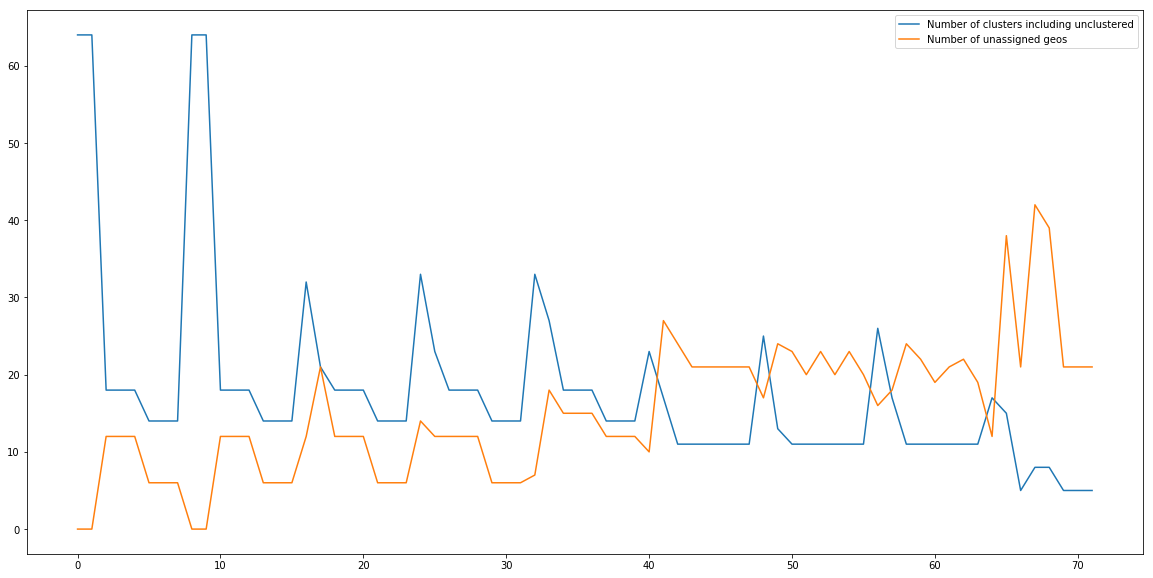

,min_samples,min_cluster_size,num_clusters_including_unclustered,number_of_unclustered_geos,percent_of_unclustered_geos,percent_of_maxclass
71,9,9,5,21,10.94,59.38
69,7,9,5,21,10.94,59.38
66,4,9,5,21,10.94,59.38
70,8,9,5,21,10.94,59.38
68,6,9,8,39,20.31,20.31


In [4]:
# Part 1 of the analysis
# STEP1: Get files list
dfiles = get_files_list(input_dir=DATA)

# STEP2: Read data
ddata = read_data(files_list=dfiles)
# STEP3: Check data 
dcheck = check_data(ddict=ddata)
# STEP4: Concat data 
ddf = concat_data1(ddict=ddata)
# STEP5: Create output dir
create_output_dir(output_dir=Config.output)
# STEP6: Fine tune and analyze the data and obtain the output of paramaters
tmp = evaluate_hdbscan(input_df=ddf, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=DATA, prune=False)
tmp.sort_values(by='num_clusters_including_unclustered', ascending=True).head()

In [15]:
# Part 2 of the analysis
# STEP1: Get files list
dfiles = get_files_list(input_dir=DATA)
print(dfiles)
# STEP2: Read data
ddata = read_data(files_list=dfiles)
# STEP3: Check data 
dcheck = check_data(ddict=ddata)
# STEP4: Concat data 
ddf = concat_data2(ddict=ddata)


geofile = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/MSVSB PSU 2015.xlsx'
geodata = pd.read_excel(geofile, sheet_name="PSU 2012")
geodata['dv'] = geodata['dv'].astype(str)
geodata['zl'] = geodata['zl'].astype(str)
geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name']]
geodata = geodata.drop_duplicates()
display(geodata.head())
d = ddf.merge(right=geodata, left_on='geo', right_on='zl')
print(d.shape)
d = d.drop(['dv', 'Div_Name', 'zl', 'Zila_Name', 'geo'], axis=1)
d.rename(columns={'geo_full':'geo'}, inplace=True)
d.head()



# STEP5: Create output dir
create_output_dir(output_dir=Config.output)
# STEP6: Run clustering
datad = cluster_data(input_df=d, f_min_samples=9, f_min_cluster_size=9)
# STEP9:

# STEP7: Run color mapping
# datad, labs_cols = colors2clusters(df_input=datad, cluster_var='class')
# STEP8: 
# datad.head()
# plot_clusters(input_df=datad, shapefile=SHAPEFILE, geo_level=GEO_LEVEL, project=Config.project, output=Config.output)

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/hdbscan/demo_2015.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/hdbscan/demo_2016.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/hdbscan/demo_2017.csv']


,geo_full,dv,Div_Name,zl,Zila_Name
0,1004,10,Barisal,04,Barguna
17,1006,10,Barisal,06,Barisal
111,1009,10,Barisal,09,Bhola
143,1042,10,Barisal,42,Jhalokati
157,1078,10,Barisal,78,Patuakhali


(192, 42)
Directory already present!


In [16]:
display(datad.head())
datad

,no_births,no_live_births,no_registered_births,prop_registered_births,prop_attendant_delivery,no_deaths,no_deaths_rural,prop_deaths_rural,no_deaths_<5y,no_deaths_1-4y,...,rate_live_births,rate_fertility,rate_death,rate_child_death,rate_under5y_mortality,rate_infant_mortality,rate_maternal_mortality,year,geo,class
0,229,225,15,0.07,0.79,53,41,0.77,6,0,...,18.28,67.91,4.23,0.0,26.67,26.67,0.0,2015,4001,3
1,229,225,15,0.07,0.79,53,41,0.77,6,0,...,18.28,67.91,4.23,0.0,26.67,26.67,0.0,2016,4001,3
2,229,225,15,0.07,0.79,53,41,0.77,6,0,...,18.28,67.91,4.23,0.0,26.67,26.67,0.0,2017,4001,3
3,91,91,0,0.00,0.60,15,10,0.67,4,3,...,19.59,74.65,3.23,10.6,43.96,10.99,0.0,2015,2003,3
4,91,91,0,0.00,0.60,15,10,0.67,4,3,...,19.59,74.65,3.23,10.6,43.96,10.99,0.0,2016,2003,3


In [46]:


tem = get_statistics(input_df=datad, output=Config.output, title=Config.project)